# MNIST with sklearn

The goal of this exercise is to 
* explore some of the sklearn functionality for training a MLP classifier (see https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier)  
* by using cross validation 
* learn how to compute the confusion matrix and its derived quantities and how to interpret them
* explore the test error as a function of the complexity (number of units, number of layers)
* explore the impact of L2 regularisation

__IMPORTANT REMARK__: We here follow the convention of sklearn to enumerate the samples with the first index. 

In [13]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

## Load and prepare the data 

In [2]:
datadir = '/tmp/data'

In [3]:
def normalize(x_train,x_test):
    """
    Normalizes the pixels values of the images - mean and stdev are computed from the training set.
    
    Parameters:
    x_train -- Array of training samples of shape (n,m1) where n,m1 are the number of features and samples, respectively.  
    x_test -- Array of test samples of shape (n,m2) where n,m2 are the number of features and samples, respectively. 
    
    Returns:
    The arrays with the normalized train and test samples.  
    """
    mean = np.mean(x_train)
    std = np.std(x_train)
    x_train -= mean
    x_test -= mean
    x_train /= std
    x_test /= std
    return x_train, x_test

In [4]:
x,y = fetch_openml('mnist_784', data_home=datadir, return_X_y=True)
x_train0, x_test0, y_train, y_test = train_test_split(x, y, test_size=10000, random_state=1)
x_train, x_test = normalize(x_train0, x_test0)

In [5]:
x_train.shape

(60000, 784)

In [6]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=.1, random_state=1)

In [7]:
x_train.shape

(54000, 784)

## Specify Model Family and learn how to compute the metrics

#### Model
Use the functionality of scikit learn to configure a MLP and its training procedure with
* hidden layers: 0-2 layers with suitable number of units per layer
* mini-batch gradient descent with given batch_size (no advanced optimisers)
* constant learning rate (no learning rate schedules)
* number of epochs
* no regularisation such as L2 penalty or early stopping

#### Metrics
Compute the train and test error resp. accuracy as well as the class precision, recall, f1-score.

__See__:
* https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier
* https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics

## First Training Run

Run the training and plot the training loss with a first set of values:
* no hidden layers
* mini-batchsize: 64
* learning rate: 0.1
* 100 epochs

Compute the Metrics.
Which digits are hard to predict?  

#### MODEL

In [8]:
# Basic Hyperparameters
hidden_layer_sizes = ()
batch_size = 64
learning_rate = 0.1
nepochs = 100

# Regularisation:
alpha = 0.0 # L2 regularisation constant
early_stopping = False
n_iter_no_change = 10

### START YOUR CODE ###
# Model instantiation and training

cls = MLPClassifier(
    hidden_layer_sizes=hidden_layer_sizes,
    alpha=alpha, batch_size=batch_size,
    learning_rate_init=learning_rate,
    early_stopping=early_stopping,
    n_iter_no_change=n_iter_no_change,
    max_iter=nepochs)

cls.fit(x_train, y_train)

MLPClassifier(alpha=0.0, batch_size=64, hidden_layer_sizes=(),
              learning_rate_init=0.1, max_iter=100)

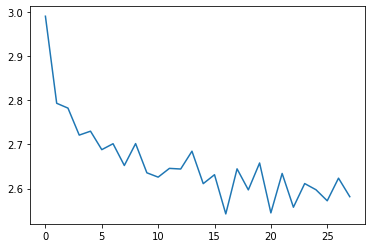

In [9]:
# Plot loss curve


plt.plot(range(len(cls.loss_curve_)), cls.loss_curve_)


### END YOUR CODE ###

#### METRICS

In [10]:
### START YOUR CODE ###

# train and test error, accuracy
# per class accuracy, precision, f1 score
y_pred = cls.predict(x_val)

print(classification_report(y_val, y_pred))

print(f1_score(y_val, y_pred, average="macro"))

### END YOUR CODE ###

              precision    recall  f1-score   support

           0       0.96      0.94      0.95       608
           1       0.93      0.98      0.95       700
           2       0.90      0.87      0.89       617
           3       0.90      0.85      0.87       603
           4       0.93      0.89      0.91       538
           5       0.88      0.80      0.84       526
           6       0.85      0.98      0.91       573
           7       0.93      0.88      0.90       614
           8       0.87      0.79      0.83       640
           9       0.79      0.92      0.85       581

    accuracy                           0.89      6000
   macro avg       0.89      0.89      0.89      6000
weighted avg       0.89      0.89      0.89      6000

0.890469322526972


## Best Model without Hidden Layer

By first varying just the parameters 
* mini-batchsize
* learning rate
* epochs

with adding any hidden layer.

Summarize what the best combination of the abover hyper-parameters is.

In [9]:
import itertools

def explore_basic_hyperparams(
        hidden_layer_size,
        early_stopping = False,
        n_iter_no_change = 10,
        alphas = [0.0], # L2 regularisation constant
        batch_sizes = [16, 32, 64, 128],
        learning_rates = [0.001, 0.01, 0.1, 1],
        nepochss = [100, 200]):
    f1s = []
    params = list(itertools.product(batch_sizes, learning_rates, nepochss, alphas))

    i = 0
    for batch_size, learning_rate, nepochs, alpha in params:
        print(batch_size, "; ", learning_rate, "; ", nepochs, "; ", alpha, "; ", f" ({i} / {len(params)})", end="\r")
        i += 1
        # Model instantiation and training

        cls = MLPClassifier(
            hidden_layer_sizes=hidden_layer_size,
            alpha=alpha, batch_size=batch_size,
            learning_rate_init=learning_rate,
            early_stopping=early_stopping,
            n_iter_no_change=n_iter_no_change,
            max_iter=nepochs)

        cls.fit(x_train, y_train)
        y_pred = cls.predict(x_val)
        f1 = f1_score(y_val, y_pred, average="macro")
        f1s.append(f1)

    max_idx = np.argmax(f1s)
    print(f"best params are {params[max_idx]} with f1 of {f1s[max_idx]}")
    return params[max_idx], f1s[max_idx], f1s

In [11]:
### START YOUR CODE ###

# Keep hidden_layer_sizes = () 
# Vary the following
params, f1, f1s = explore_basic_hyperparams(hidden_layer_size=())
### END YOUR CODE ###

c:\users\local user\appdata\local\programs\python\python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


c:\users\local user\appdata\local\programs\python\python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


c:\users\local user\appdata\local\programs\python\python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


best params are (64, 0.001, 100, 0.0) with f1 of 0.9164874906098648


In [23]:
cls = MLPClassifier(
    hidden_layer_sizes=(),
    alpha=0.0, batch_size=64,
    learning_rate_init=0.001,
    early_stopping=False,
    n_iter_no_change=10,
    max_iter=100)

cls.fit(x_train, y_train)

y_pred = cls.predict(x_train)
print(classification_report(y_train, y_pred))

y_pred = cls.predict(x_val)
print(classification_report(y_val, y_pred))
print(f1_score(y_val, y_pred, average="macro"))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      5336
           1       0.98      0.97      0.98      5991
           2       0.93      0.93      0.93      5338
           3       0.93      0.92      0.92      5507
           4       0.94      0.95      0.95      5345
           5       0.92      0.90      0.91      4857
           6       0.97      0.97      0.97      5361
           7       0.97      0.92      0.94      5629
           8       0.91      0.92      0.91      5249
           9       0.89      0.94      0.91      5387

    accuracy                           0.94     54000
   macro avg       0.94      0.94      0.94     54000
weighted avg       0.94      0.94      0.94     54000

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       608
           1       0.97      0.97      0.97       700
           2       0.89      0.90      0.89       617
           3       0.91 

__BEST MODEL__ (no hidden layer)

batch_size = 64

learning_rate = 0.001

nepochs = 100

train / validation error : 6% / 8%

## Adding one Hidden layer

Explore the performance of the model by varying the parameters 
* mini-batchsize
* learning rate
* epochs
* complexity (number of units in the one hidden layer)

For given complexity, summarize what the best combination of other hyper-parameters is - compute this for several complexities.

Compute also the "best" train and validation error (or accuracy) for given complexity - as a function of the complexity and plot the curve (for selected number of units - e.g. 10 different values). 


In [15]:
### START YOUR CODE ###

# Keep hidden_layer_sizes = () 
# Vary the following

hidden_layer_sizes = [(int(x),) for x in np.linspace(10, 1000, 10)] # just one layer 

f1s = []

i = 0
for hidden_layer_size in hidden_layer_sizes:
    print(f"working on {hidden_layer_size}, ({i}/{len(hidden_layer_sizes)})")
    i += 1
    params, f1, _ = explore_basic_hyperparams(
        hidden_layer_size=hidden_layer_size,
        batch_sizes = [64],
        learning_rates = [0.001],
        nepochss = [100]
    )
    
    f1s.append(f1)

### END YOUR CODE ###

working on (10,), (0/10)


c:\users\local user\appdata\local\programs\python\python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


best params are (64, 0.001, 100, 0.0) with f1 of 0.9377670020276868
working on (120,), (1/10)
best params are (64, 0.001, 100, 0.0) with f1 of 0.9714356388215828
working on (230,), (2/10)
best params are (64, 0.001, 100, 0.0) with f1 of 0.9768826121000667
working on (340,), (3/10)
best params are (64, 0.001, 100, 0.0) with f1 of 0.9767490083664164
working on (450,), (4/10)
best params are (64, 0.001, 100, 0.0) with f1 of 0.9783789728258366
working on (560,), (5/10)
best params are (64, 0.001, 100, 0.0) with f1 of 0.9776119045413489
working on (670,), (6/10)
best params are (64, 0.001, 100, 0.0) with f1 of 0.9773969367396177
working on (780,), (7/10)
best params are (64, 0.001, 100, 0.0) with f1 of 0.9797487838086119
working on (890,), (8/10)
best params are (64, 0.001, 100, 0.0) with f1 of 0.9786351263486133
working on (1000,), (9/10)
best params are (64, 0.001, 100, 0.0) with f1 of 0.977659304379128


__Error vs Complexity__:

Plot with the train and test error vs complexity (number of units in the hidden layer)

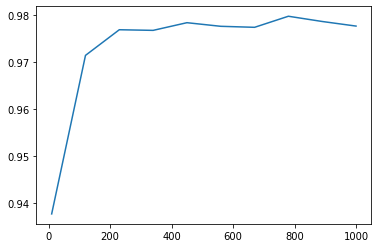

In [16]:
### START YOUR CODE ###


plt.plot(np.linspace(10, 1000, 10), f1s)


### END YOUR CODE ###

In [24]:
cls = MLPClassifier(
    hidden_layer_sizes=(780,),
    alpha=0.0, batch_size=64,
    learning_rate_init=0.001,
    early_stopping=False,
    n_iter_no_change=10,
    max_iter=100)

cls.fit(x_train, y_train)

y_pred = cls.predict(x_train)
print(classification_report(y_train, y_pred))

y_pred = cls.predict(x_val)
print(classification_report(y_val, y_pred))

print(f1_score(y_val, y_pred, average="macro"))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5336
           1       1.00      1.00      1.00      5991
           2       1.00      1.00      1.00      5338
           3       1.00      1.00      1.00      5507
           4       1.00      1.00      1.00      5345
           5       1.00      0.99      1.00      4857
           6       1.00      1.00      1.00      5361
           7       1.00      1.00      1.00      5629
           8       1.00      1.00      1.00      5249
           9       1.00      0.99      1.00      5387

    accuracy                           1.00     54000
   macro avg       1.00      1.00      1.00     54000
weighted avg       1.00      1.00      1.00     54000

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       608
           1       0.98      0.99      0.99       700
           2       0.96      0.98      0.97       617
           3       0.98 

__BEST MODEL__ (one hidden layer)

hidden_layer_sizes = (780,)

batch_size = 64

learning_rate = 0.001

nepochs = 100

train / validation error : TBD


## Impact of Regularisation

Explore the Impact of Using L2 Regularisation (still adding just one hidden layer) again by varying mini-batchsize, learning rate, epochs, complexity.

Can you reach a better best model performance (on validation set)?

In [14]:
### START YOUR CODE ###

# Vary the following

hidden_layer_sizes = [(int(x),) for x in np.linspace(10, 1000, 10)] # just one layer 

f1s = []

i = 0
for hidden_layer_size in hidden_layer_sizes:
    print(f"working on {hidden_layer_size}, ({i}/{len(hidden_layer_sizes)})")
    i += 1
    params, f1, _ = explore_basic_hyperparams(
        hidden_layer_size=hidden_layer_size,
        alphas=[0.1],
        batch_sizes = [64],
        learning_rates = [0.001],
        nepochss = [100]
    )
    
    f1s.append(f1)

### END YOUR CODE ###

working on (10,), (0/10)
best params are (64, 0.001, 100, 0.1) with f1 of 0.9343281241336587
working on (120,), (1/10)
best params are (64, 0.001, 100, 0.1) with f1 of 0.9732616830863468
working on (230,), (2/10)


c:\users\local user\appdata\local\programs\python\python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


best params are (64, 0.001, 100, 0.1) with f1 of 0.9734140911490451
working on (340,), (3/10)
best params are (64, 0.001, 100, 0.1) with f1 of 0.9702956366384206
working on (450,), (4/10)


c:\users\local user\appdata\local\programs\python\python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


best params are (64, 0.001, 100, 0.1) with f1 of 0.96872563123109
working on (560,), (5/10)
best params are (64, 0.001, 100, 0.1) with f1 of 0.9734270013667219
working on (670,), (6/10)
best params are (64, 0.001, 100, 0.1) with f1 of 0.966933826008605
working on (780,), (7/10)
best params are (64, 0.001, 100, 0.1) with f1 of 0.9746087537355829
working on (890,), (8/10)
best params are (64, 0.001, 100, 0.1) with f1 of 0.9732025754410492
working on (1000,), (9/10)
best params are (64, 0.001, 100, 0.1) with f1 of 0.9755967830618145


__Error vs Complexity__:

Plot with the train and test error vs complexity (number of units in the hidden layer)

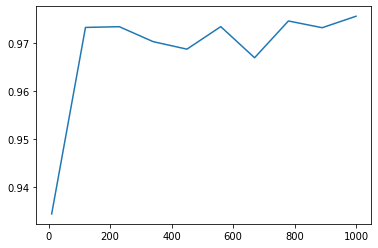

In [15]:
### START YOUR CODE ###


plt.plot(np.linspace(10, 1000, 10), f1s)


### END YOUR CODE ###

In [ ]:
cls = MLPClassifier(
    hidden_layer_sizes=(780),
    alpha=0.1, batch_size=64,
    learning_rate_init=0.001,
    early_stopping=False,
    n_iter_no_change=10,
    max_iter=100)

cls.fit(x_train, y_train)

y_pred = cls.predict(x_train)
print(classification_report(y_train, y_pred))

y_pred = cls.predict(x_val)
print(classification_report(y_val, y_pred))

print(f1_score(y_val, y_pred, average="macro"))

__BEST MODEL__ (one hidden layer)

hidden_layer_sizes = (*,)

batch_size = 

learning_rate = 

nepochs = 

alpha =  # L2 regularisation constant

train / validation error :

## Adding up to 3 Hidden Layers

Now consider using a model with more than one hidden layer (at max 3).


In [16]:
### START YOUR CODE ###

# Vary the following

hidden_layer_sizes =  [(int(x),) for x in np.linspace(10, 500, 5)] # single
hidden_layer_sizes += [(int(x),int(x)) for x in np.linspace(10, 500, 5)] # double
hidden_layer_sizes += [(int(x),int(x), int(x)) for x in np.linspace(10, 500, 5)] # trible

f1s = []

i = 0
for hidden_layer_size in hidden_layer_sizes:
    print(f"working on {hidden_layer_size}, ({i}/{len(hidden_layer_sizes)})")
    i += 1
    params, f1, _ = explore_basic_hyperparams(
        hidden_layer_size=hidden_layer_size,
        alphas=[0, 0.1],
        batch_sizes = [64],
        learning_rates = [0.001],
        nepochss = [100]
    )
    
    f1s.append(f1)

### END YOUR CODE ###

working on (10,), (0/15)


c:\users\local user\appdata\local\programs\python\python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


best params are (64, 0.001, 100, 0.1) with f1 of 0.938253112600927
working on (132,), (1/15)
best params are (64, 0.001, 100, 0) with f1 of 0.9764276390626115
working on (255,), (2/15)
best params are (64, 0.001, 100, 0) with f1 of 0.9773133570399615
working on (377,), (3/15)
best params are (64, 0.001, 100, 0) with f1 of 0.9762641932423037
working on (500,), (4/15)
best params are (64, 0.001, 100, 0) with f1 of 0.9741160747006911
working on (10, 10), (5/15)


c:\users\local user\appdata\local\programs\python\python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


c:\users\local user\appdata\local\programs\python\python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


best params are (64, 0.001, 100, 0.1) with f1 of 0.9389334773154907
working on (132, 132), (6/15)
best params are (64, 0.001, 100, 0) with f1 of 0.9736348957138977
working on (255, 255), (7/15)
best params are (64, 0.001, 100, 0) with f1 of 0.9749532379447567
working on (377, 377), (8/15)
best params are (64, 0.001, 100, 0) with f1 of 0.9757152505645748
working on (500, 500), (9/15)
best params are (64, 0.001, 100, 0) with f1 of 0.9799861171130051
working on (10, 10, 10), (10/15)


c:\users\local user\appdata\local\programs\python\python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


c:\users\local user\appdata\local\programs\python\python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


best params are (64, 0.001, 100, 0.1) with f1 of 0.9328306686987459
working on (132, 132, 132), (11/15)
best params are (64, 0.001, 100, 0) with f1 of 0.9758523311981122
working on (255, 255, 255), (12/15)
best params are (64, 0.001, 100, 0) with f1 of 0.9765511683397549
working on (377, 377, 377), (13/15)
best params are (64, 0.001, 100, 0) with f1 of 0.9812044778512071
working on (500, 500, 500), (14/15)
best params are (64, 0.001, 100, 0) with f1 of 0.9774444616853003


__Error vs Complexity__:

Plot with the train and test error vs complexity (number of units in the hidden layer)

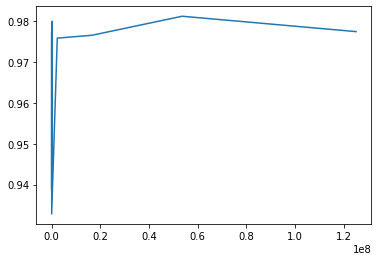

In [17]:
### START YOUR CODE ###


plt.plot([np.prod(y) for y in hidden_layer_sizes], f1s)


### END YOUR CODE ###

In [ ]:
cls = MLPClassifier(
    hidden_layer_sizes=(377, 377, 377),
    alpha=0.0, batch_size=64,
    learning_rate_init=0.001,
    early_stopping=False,
    n_iter_no_change=10,
    max_iter=100)

cls.fit(x_train, y_train)


y_pred = cls.predict(x_train)
print(classification_report(y_train, y_pred))

y_pred = cls.predict(x_val)
print(classification_report(y_val, y_pred))

print(f1_score(y_val, y_pred, average="macro"))

__BEST MODEL__ (1-3 hidden layers)

hidden_layer_sizes = (*,*,*)

batch_size = 

learning_rate = 

nepochs = 

alpha =  # L2 regularisation constant

train / validation error :

## Test Performance of Best Model

Test Error: 

In [ ]:
cls = MLPClassifier(
    hidden_layer_sizes=(),
    alpha=0.0, batch_size=64,
    learning_rate_init=0.001,
    early_stopping=False,
    n_iter_no_change=10,
    max_iter=100)

cls.fit(x_train, y_train)

y_pred = cls.predict(x_test)

print(classification_report(y_test, y_pred))
print(f1_score(y_test, y_pred, average="macro"))